In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [30]:
from multiproduct import generate_dataset
n_nodes, supplies, demands, costs, capacities = generate_dataset(
                nodes=20, levels=4, total_supplies=[500,400,300], 
                total_demands=[400,600,400], transp_costs=(10,100), 
                random_state=42)

In [36]:
from multiproduct import generate_ampl
generate_ampl(n_nodes, supplies, demands, costs, capacities, 
              output_file='modelos/test_20_4.mod')

In [31]:
n_nodes

[5, 6, 3, 6]

In [32]:
np.random.seed(42)
n_items = len(supplies)
chromosome = np.random.permutation(sum([n_items * sum(n_nodes[1:])]))

In [33]:
from multiproduct import transportation_tree
X = transportation_tree(chromosome, n_nodes, supplies, demands, 
                        costs, capacities)

In [123]:
X[-1]

array([[[100.,  20.,   0.,  40.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,  50.,   0., 110.,  80.]],

       [[  0.,  50.,   0., 120.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,  70., 160.]],

       [[  0.,  60.,   0.,  30.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,  80.,   0.,  40.,  90.]]])

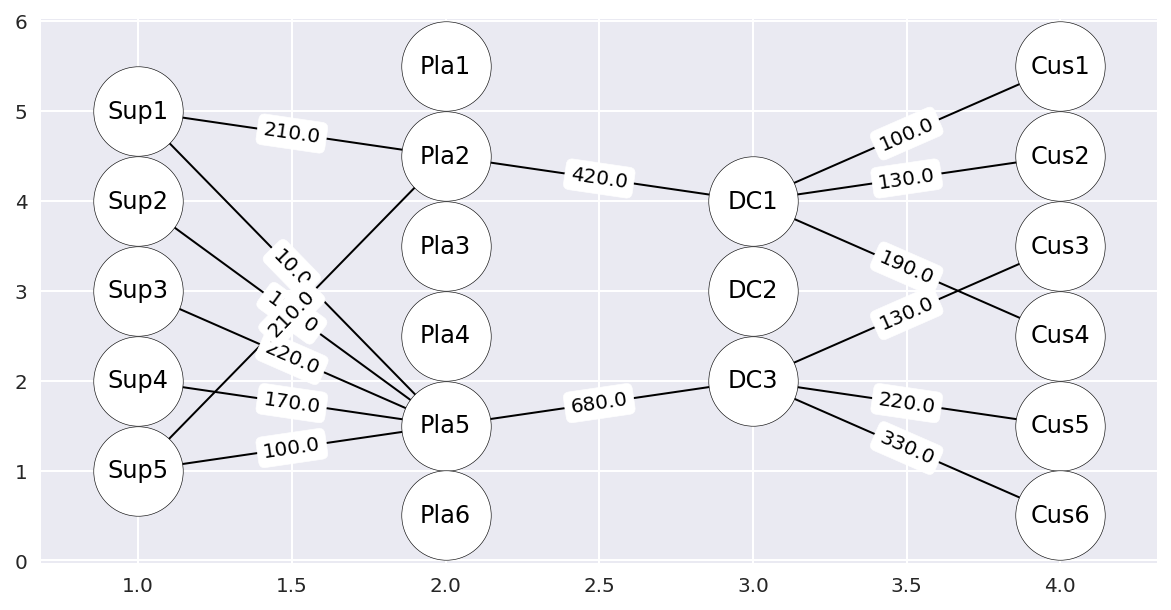

In [34]:
from utils import plot_graph
plot_graph(np.sum(X[0], 0), np.sum(X[1], 0), np.sum(X[2], 0))

## Genetic Algorithm

In [74]:
# minimum fairness
np.sqrt(((np.divide(X[-1].sum(1), np.array(demands)[:,:-1]).sum() / 18) ** 2) * 18 / 18)

0.793154761904762

In [70]:
# current fairness
np.sqrt((np.divide(X[-1].sum(1), np.array(demands)[:,:-1]) ** 2).sum() / 18)

0.8764388275424796

In [77]:
def chromosome_fitness(chromosome, n_nodes, supplies, demands,
                       costs, capacities):
    X = transportation_tree(chromosome, n_nodes, supplies, demands, 
                        costs, capacities)
    transportation_cost = sum(np.multiply(x.sum(0), c).sum() \
                               for c, x in zip(costs, X))
    fairness = (np.divide(X[-1].sum(1), np.array(demands)[:,:-1]) ** 2).sum()
    return transportation_cost, fairness

In [78]:
chromosome_fitness(chromosome, n_nodes, supplies, demands, costs, capacities)

(91430.0, 13.826610331632653)

In [79]:
import random
from deap import creator, base, tools, algorithms

In [ ]:
del creator.FitnessMin
del creator.Individual

In [84]:
creator.create('FitnessMin', base.Fitness, weights=(-1.0,-1.0))
creator.create('Individual', list, fitness=creator.FitnessMin)

In [85]:
def create_chromosome(permutation_size):
    perm = np.random.permutation(permutation_size).astype(int)
    return list(perm)

In [90]:
chromosome_size = sum([n_items * sum(n_nodes[1:])])

In [91]:
toolbox = base.Toolbox()
toolbox.register('chromosome', create_chromosome, 
                permutation_size=chromosome_size)
toolbox.register('individual', tools.initIterate, creator.Individual,
                toolbox.chromosome)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

In [92]:
from functools import partial
ga_fitness = lambda x: partial(chromosome_fitness, 
                         n_nodes=n_nodes, supplies=supplies, 
                         demands=demands, costs=costs, 
                         capacities=capacities)(x)

In [93]:
def custom_crossover(ind1, ind2, permutation_size):
    perm1 = ind1[:permutation_size]
    perm2 = ind2[:permutation_size]
    perm_child1, perm_child2 = tools.cxPartialyMatched(perm1, perm2)
    child1 = list(perm_child1)
    child2 = list(perm_child2)
    for i, x in enumerate(child1):
        ind1[i] = child1[i]
        ind2[i] = child2[i]
    return ind1, ind2

In [94]:
def custom_mutation(ind, permutation_size):
    perm = ind[:permutation_size]
    perm_mut = tools.mutShuffleIndexes(perm, 2.0/len(perm))
    mut = list(perm_mut[0]) 
    for i, x in enumerate(mut):
        ind[i] = mut[i]
    return ind,

In [95]:
toolbox.register('evaluate', ga_fitness)
toolbox.register('mate', custom_crossover, 
                         permutation_size=chromosome_size)
toolbox.register('mutate', custom_mutation,
                         permutation_size=chromosome_size)
toolbox.register('select', tools.selNSGA2)

In [115]:
toolbox.pop_size = 50

In [116]:
import copy
pop = toolbox.population(n=toolbox.pop_size)
hof = tools.HallOfFame(20)
stats = tools.Statistics()
stats.register("pop", copy.deepcopy)

In [117]:
pop, log = algorithms.eaMuPlusLambda(pop, toolbox, 
                                     mu=toolbox.pop_size,
                                     lambda_=toolbox.pop_size,
                                     cxpb=0.5, mutpb=0.2, ngen=70, 
                    stats=stats, halloffame=hof, verbose=False)

In [109]:
def plot_fronts(fronts):
    plot_colors = sns.color_palette("Set1", n_colors=10)
    fig, ax = plt.subplots(1, figsize=(6,6))
    for i,inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)
        df.plot(ax=ax, kind='scatter', label='Front ' + str(i+1), 
                     x=df.columns[0], y=df.columns[1], 
                     color=plot_colors[i % len(plot_colors)])
    plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$')

In [118]:
fronts = tools.emo.sortLogNondominated(pop, len(pop))

In [120]:
from matplotlib import animation
from IPython.display import HTML

def animate(frame_index, logbook):
    plot_colors = sns.color_palette("Set1", n_colors=10)
    'Updates all plots to match frame _i_ of the animation.'
    ax.clear()    
    fronts = tools.emo.sortLogNondominated(logbook.select('pop')[frame_index], 
                                           len(logbook.select('pop')[frame_index]))
    for i,inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)
        df.plot(ax=ax, kind='scatter', label='Front ' + str(i+1), 
                 x=df.columns[0], y=df.columns[1], alpha=0.47,
                 color=plot_colors[i % len(plot_colors)])
        
    ax.set_title('$t=$' + str(frame_index))
    ax.set_xlabel('$f_1(\mathbf{x})$');ax.set_ylabel('$f_2(\mathbf{x})$')
    return []

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
anim = animation.FuncAnimation(fig, lambda i: animate(i, log), 
                               frames=len(log), interval=1000, 
                               blit=True)
plt.close()

In [121]:
HTML(anim.to_html5_video())

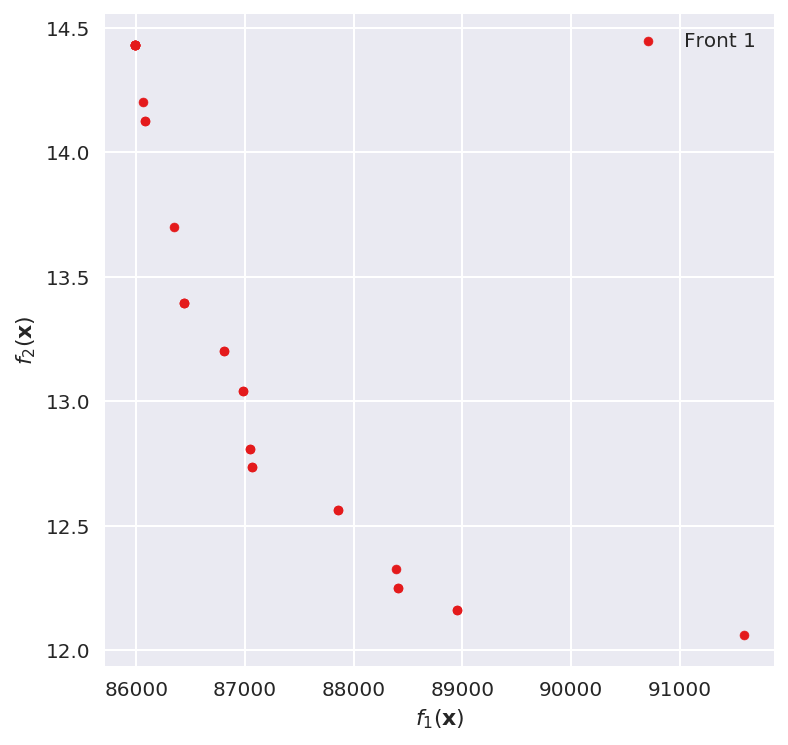

In [101]:
plot_fronts(fronts)

In [105]:
sorted([item.fitness.values[0] + item.fitness.values[1] * 10000 \
        for item in pop])

[210550.0,
 210550.0,
 210910.0,
 210910.0,
 211654.306122449,
 212215.0,
 213484.0,
 213484.0,
 214415.9387755102,
 214415.9387755102,
 215149.0,
 215149.0,
 217379.0,
 217379.0,
 218815.25,
 218815.25,
 220387.5012755102,
 220387.5012755102,
 220387.5012755102,
 223350.5625,
 227332.1887755102,
 227332.1887755102,
 228065.25,
 230295.25,
 230295.25,
 230295.25,
 230295.25,
 230295.25,
 230295.25,
 230295.25]